In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pandas.tseries.offsets import BQuarterEnd
from ipywidgets import interactive
from pandarallel import pandarallel
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore') #

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
stock_sparsity = pd.read_csv('2024_04_20_stock_sparsity_ret_coverage_ratio.csv')

#### Filter it to after 1985

In [4]:
# Assuming stock_sparsity is your dataframe
# First, ensure the 'quarter' column is recognized as a string to perform string operations
stock_sparsity['quarter'] = stock_sparsity['quarter'].astype(str)

# Filter rows where the year part of the 'quarter' column is greater than 1985
# The year part can be extracted by splitting the string and taking the first part
stock_sparsity_filtered = stock_sparsity[stock_sparsity['quarter'].apply(lambda x: int(x.split('Q')[0]) > 1984)]

In [5]:
stock_sparsity = stock_sparsity_filtered

In [6]:
stock_sparsity

,permno,quarter,percent_benchmark_3_equ_w_mean,percent_benchmark_7_equ_w_mean,percent_benchmark_11_equ_w_mean,percent_benchmark_15_equ_w_mean,percent_benchmark_19_equ_w_mean,percent_within_3_equ_w_mean,percent_within_7_equ_w_mean,percent_within_11_equ_w_mean,percent_within_15_equ_w_mean,percent_within_19_equ_w_mean,percent_benchmark_median_passive_equ_w_mean,percent_benchmark_avg_passive_equ_w_mean,percent_benchmark_largest_passive_equ_w_mean,percent_benchmark_0_equ_w_mean,percent_benchmark_3_ow_weighted,percent_benchmark_7_ow_weighted,percent_benchmark_11_ow_weighted,percent_benchmark_15_ow_weighted,percent_benchmark_19_ow_weighted,percent_within_3_ow_weighted,percent_within_7_ow_weighted,percent_within_11_ow_weighted,percent_within_15_ow_weighted,percent_within_19_ow_weighted,percent_benchmark_median_passive_ow_weighted,percent_benchmark_avg_passive_ow_weighted,percent_benchmark_largest_passive_ow_weighted,percent_benchmark_0_ow_weighted,percent_within_3_coverage_ratio,percent_within_7_coverage_ratio,percent_within_11_coverage_ratio,percent_within_15_coverage_ratio,percent_within_19_coverage_ratio,percent_benchmark_0_coverage_ratio,percent_benchmark_3_coverage_ratio,percent_benchmark_7_coverage_ratio,percent_benchmark_11_coverage_ratio,percent_benchmark_15_coverage_ratio,percent_benchmark_19_coverage_ratio,percent_benchmark_median_passive_coverage_ratio,percent_benchmark_avg_passive_coverage_ratio,percent_benchmark_largest_passive_coverage_ratio,forward_0_avg_RET,forward_3_avg_RET,forward_7_avg_RET,forward_11_avg_RET,forward_15_avg_RET,forward_19_avg_RET,forward_0_avg_alpha,forward_3_avg_alpha,forward_7_avg_alpha,forward_11_avg_alpha,forward_15_avg_alpha,forward_19_avg_alpha,num_available_quarters_ret_0,num_available_quarters_ret_3,num_available_quarters_ret_7,num_available_quarters_ret_11,num_available_quarters_ret_15,num_available_quarters_ret_19,num_available_quarters_alpha_0,num_available_quarters_alpha_3,num_available_quarters_alpha_7,num_available_quarters_alpha_11,num_available_quarters_alpha_15,num_available_quarters_alpha_19
0,10001,1993Q4,NaN,NaN,NaN,NaN,NaN,0.978810,0.978810,0.978810,0.978810,0.978810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978810,0.978810,0.978810,0.978810,0.978810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000712,-0.000004,0.000726,0.000542,0.000656,0.000641,0.001160,0.000963,0.000711,0.000553,0.000456,0.000428,1.0,4.0,8.0,12.0,16.0,20.0,1.0,4.0,8.0,12.0,16.0,20.0
1,10001,1994Q1,NaN,NaN,NaN,NaN,NaN,0.956258,0.941814,0.937538,0.937538,0.937538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.951808,0.933620,0.928033,0.928033,0.928033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000526,0.000135,0.000958,0.000754,0.000688,0.000627,0.000969,0.000811,0.000623,0.000462,0.000401,0.000388,1.0,4.0,8.0,12.0,16.0,20.0,1.0,4.0,8.0,12.0,16.0,20.0
2,10001,1994Q2,NaN,NaN,NaN,NaN,NaN,0.963313,0.953012,0.948519,0.948519,0.948519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.965632,0.952818,0.946948,0.946948,0.946948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001682,0.000653,0.000623,0.000710,0.000664,0.000614,0.001017,0.000710,0.000537,0.000406,0.000356,0.000359,1.0,4.0,8.0,12.0,16.0,20.0,1.0,4.0,8.0,12.0,16.0,20.0
3,10001,1994Q3,NaN,NaN,NaN,NaN,NaN,0.968474,0.951422,0.947058,0.947058,0.947058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.966233,0.946068,0.940365,0.940365,0.940365,NaN,NaN,NaN,NaN,0.004679,0.004679,0.004679,0.004679,0.004679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001511,0.000412,0.000662,0.000710,0.000651,0.000504,0.000703,0.000563,0.000434,0.000332,0.000317,0.000331,1.0,4.0,8.0,12.0,16.0,20.0,1.0,4.0,8.0,12.0,16.0,20.0
4,10001,1994Q4,NaN,NaN,NaN,NaN,NaN,0.990351,0.981302,0.975410,0.975410,0.975410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.987407,0.973160,0.962410,0.962410,0.962410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000155,0.001456,0.000815,0.000876,0.000803,0.000651,0.000554,0.000460,0.000349,0.000

#### Compute the deciles 
- Note: Decile 1 has the highest sparsity measure

In [7]:
# Convert 'quarter' to string for string operations
stock_sparsity['quarter'] = stock_sparsity['quarter'].astype(str)

# Extract year and quarter number for easier manipulation
stock_sparsity['year'] = stock_sparsity['quarter'].str[:4].astype(int)
stock_sparsity['qtr'] = stock_sparsity['quarter'].str[-1:].astype(int)

#### fliter Quarter2 data to compute deciles

In [8]:
# Filter for Q2 data
q2_data = stock_sparsity[stock_sparsity['qtr'] == 2]

In [10]:
q2_data.columns[2:30]

Index(['percent_benchmark_3_equ_w_mean', 'percent_benchmark_7_equ_w_mean',
       'percent_benchmark_11_equ_w_mean', 'percent_benchmark_15_equ_w_mean',
       'percent_benchmark_19_equ_w_mean', 'percent_within_3_equ_w_mean',
       'percent_within_7_equ_w_mean', 'percent_within_11_equ_w_mean',
       'percent_within_15_equ_w_mean', 'percent_within_19_equ_w_mean',
       'percent_benchmark_median_passive_equ_w_mean',
       'percent_benchmark_avg_passive_equ_w_mean',
       'percent_benchmark_largest_passive_equ_w_mean',
       'percent_benchmark_0_equ_w_mean', 'percent_benchmark_3_ow_weighted',
       'percent_benchmark_7_ow_weighted', 'percent_benchmark_11_ow_weighted',
       'percent_benchmark_15_ow_weighted', 'percent_benchmark_19_ow_weighted',
       'percent_within_3_ow_weighted', 'percent_within_7_ow_weighted',
       'percent_within_11_ow_weighted', 'percent_within_15_ow_weighted',
       'percent_within_19_ow_weighted',
       'percent_benchmark_median_passive_ow_weighted',
  

#### Generate the decile for 20 stock sparisty measures

In [11]:
for i in tqdm(q2_data.columns[2:30]):
    sparsity_measure = i
    # Filter for Q2 data
    # Function to assign top and bottom deciles
    def assign_top_bottom_deciles(group):
        # Sort the group in descending order of sparsity measure
        sorted_group = group.sort_values(sparsity_measure, ascending=False)
        
        # Calculate the number of items representing 10% of the group
        decile_cutoff = int(len(sorted_group) * 0.1)
        
        # Assign decile 1 to the top 10% and decile 10 to the bottom 10%
        sorted_group['decile'] = np.nan # Assign a default value for the middle 80% if needed
        sorted_group.iloc[:decile_cutoff, sorted_group.columns.get_loc('decile')] = 1 # Locate 1 to :decile_cutoff as decile 1
        sorted_group.iloc[-decile_cutoff:, sorted_group.columns.get_loc('decile')] = 10 ## Locate -decile_cutoff: as decile 10
        
        return sorted_group
    
    # Apply the function to each year's Q2 data
    q2_data_deciles = q2_data.groupby('year').apply(assign_top_bottom_deciles).reset_index(drop=True)
    
    # Create a mapping from (year, permno) to decile
    decile_map = q2_data_deciles.set_index(['year', 'permno'])['decile'].dropna().to_dict()
    
    # Define a function to apply deciles based on the mapping
    def apply_decile_from_q2(row): 
        # For Q3 and Q4 of the current year, apply the current year's Q2 decile
        if row['quarter'].endswith('Q3') or row['quarter'].endswith('Q4'):
            # Retrieve the decile based on this year and permno
            decile = decile_map.get((row['year'], row['permno']))
            return decile if decile is not None else np.nan
    
        # For Q1 and Q2, apply the previous year's Q2 decile
        if row['quarter'].endswith('Q1') or row['quarter'].endswith('Q2'):
            # Retrieve the decile based on previous year and permno
            decile_last_yr = decile_map.get((row['year']-1, row['permno']))
            return decile_last_yr if decile_last_yr is not None else np.nan # Return None or any other indicator if the decile should not be applied
    
    # Apply the function to assign deciles based on Q2 to relevant quarters
    stock_sparsity[f'{sparsity_measure}_decile'] = stock_sparsity.apply(apply_decile_from_q2, axis=1)

    

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [02:48<00:00,  6.00s/it]


In [12]:
stock_sparsity['percent_within_3_equ_w_mean_decile'].value_counts()

percent_within_3_equ_w_mean_decile
10.0    66370
1.0     60693
Name: count, dtype: int64

In [13]:
stock_sparsity

,permno,quarter,percent_benchmark_3_equ_w_mean,percent_benchmark_7_equ_w_mean,percent_benchmark_11_equ_w_mean,percent_benchmark_15_equ_w_mean,percent_benchmark_19_equ_w_mean,percent_within_3_equ_w_mean,percent_within_7_equ_w_mean,percent_within_11_equ_w_mean,percent_within_15_equ_w_mean,percent_within_19_equ_w_mean,percent_benchmark_median_passive_equ_w_mean,percent_benchmark_avg_passive_equ_w_mean,percent_benchmark_largest_passive_equ_w_mean,percent_benchmark_0_equ_w_mean,percent_benchmark_3_ow_weighted,percent_benchmark_7_ow_weighted,percent_benchmark_11_ow_weighted,percent_benchmark_15_ow_weighted,percent_benchmark_19_ow_weighted,percent_within_3_ow_weighted,percent_within_7_ow_weighted,percent_within_11_ow_weighted,percent_within_15_ow_weighted,percent_within_19_ow_weighted,percent_benchmark_median_passive_ow_weighted,percent_benchmark_avg_passive_ow_weighted,percent_benchmark_largest_passive_ow_weighted,percent_benchmark_0_ow_weighted,percent_within_3_coverage_ratio,percent_within_7_coverage_ratio,percent_within_11_coverage_ratio,percent_within_15_coverage_ratio,percent_within_19_coverage_ratio,percent_benchmark_0_coverage_ratio,percent_benchmark_3_coverage_ratio,percent_benchmark_7_coverage_ratio,percent_benchmark_11_coverage_ratio,percent_benchmark_15_coverage_ratio,percent_benchmark_19_coverage_ratio,percent_benchmark_median_passive_coverage_ratio,percent_benchmark_avg_passive_coverage_ratio,percent_benchmark_largest_passive_coverage_ratio,forward_0_avg_RET,forward_3_avg_RET,forward_7_avg_RET,forward_11_avg_RET,forward_15_avg_RET,forward_19_avg_RET,forward_0_avg_alpha,forward_3_avg_alpha,forward_7_avg_alpha,forward_11_avg_alpha,forward_15_avg_alpha,forward_19_avg_alpha,num_available_quarters_ret_0,num_available_quarters_ret_3,num_available_quarters_ret_7,num_available_quarters_ret_11,num_available_quarters_ret_15,num_available_quarters_ret_19,num_available_quarters_alpha_0,num_available_quarters_alpha_3,num_available_quarters_alpha_7,num_available_quarters_alpha_11,num_available_quarters_alpha_15,num_available_quarters_alpha_19,year,qtr,percent_benchmark_3_equ_w_mean_decile,percent_benchmark_7_equ_w_mean_decile,percent_benchmark_11_equ_w_mean_decile,percent_benchmark_15_equ_w_mean_decile,percent_benchmark_19_equ_w_mean_decile,percent_within_3_equ_w_mean_decile,percent_within_7_equ_w_mean_decile,percent_within_11_equ_w_mean_decile,percent_within_15_equ_w_mean_decile,percent_within_19_equ_w_mean_decile,percent_benchmark_median_passive_equ_w_mean_decile,percent_benchmark_avg_passive_equ_w_mean_decile,percent_benchmark_largest_passive_equ_w_mean_decile,percent_benchmark_0_equ_w_mean_decile,percent_benchmark_3_ow_weighted_decile,percent_benchmark_7_ow_weighted_decile,percent_benchmark_11_ow_weighted_decile,percent_benchmark_15_ow_weighted_decile,percent_benchmark_19_ow_weighted_decile,percent_within_3_ow_weighted_decile,percent_within_7_ow_weighted_decile,percent_within_11_ow_weighted_decile,percent_within_15_ow_weighted_decile,percent_within_19_ow_weighted_decile,percent_benchmark_median_passive_ow_weighted_decile,percent_benchmark_avg_passive_ow_weighted_decile,percent_benchmark_largest_passive_ow_weighted_decile,percent_benchmark_0_ow_weighted_decile
0,10001,1993Q4,NaN,NaN,NaN,NaN,NaN,0.978810,0.978810,0.978810,0.978810,0.978810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978810,0.978810,0.978810,0.978810,0.978810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000712,-0.000004,0.000726,0.000542,0.000656,0.000641,0.001160,0.000963,0.000711,0.000553,0.000456,0.000428,1.0,4.0,8.0,12.0,16.0,20.0,1.0,4.0,8.0,12.0,16.0,20.0,1993,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1994Q1,NaN,NaN,NaN,NaN,NaN,0.956258,0.941814,0.937538,0.937538,0.937538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.951808,0.933620,0.928033,0.928033,0.928033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000526,0.000135,0.000958,0.000754,

#### import market_cap file and generate market_cap last month to calculate portfolio weights later

In [14]:
market_cap = pd.read_csv('Monthly_ME.csv')

In [15]:
market_cap['market_cap'] = abs(market_cap['PRC'])*market_cap['SHROUT']
market_cap['date'] = pd.to_datetime(market_cap['date'])

# Generate the 'quarter' column
market_cap['quarter'] = market_cap['date'].dt.to_period('Q').astype(str)
market_cap['month'] = market_cap['date'].dt.to_period('M')
market_cap = market_cap[['PERMNO', 'date', 'RET' ,'market_cap','quarter','month']]
# Convert 'RET' and 'market_cap' to numeric, just in case they're not
market_cap['RET'] = pd.to_numeric(market_cap['RET'], errors='coerce')
market_cap['market_cap'] = pd.to_numeric(market_cap['market_cap'], errors='coerce')

market_cap.rename(columns={'PERMNO': 'permno'}, inplace=True)

In [16]:
# Sort the DataFrame by 'permno' and 'month' to ensure chronological order within each permno
market_cap = market_cap.sort_values(by=['permno', 'month'])

# Generate the 'market_cap_last_month' by shifting the 'market_cap' within each 'permno' group
market_cap['market_cap_last_month'] = market_cap.groupby('permno')['market_cap'].shift(1)

In [17]:
market_cap

,permno,date,RET,market_cap,quarter,month,market_cap_last_month
0,10000,1985-12-31,NaN,NaN,1985Q4,1985-12,NaN
1,10000,1986-01-31,NaN,1.610000e+04,1986Q1,1986-01,NaN
2,10000,1986-02-28,-0.257143,1.196000e+04,1986Q1,1986-02,1.610000e+04
3,10000,1986-03-31,0.365385,1.633000e+04,1986Q1,1986-03,1.196000e+04
4,10000,1986-04-30,-0.098592,1.517200e+04,1986Q2,1986-04,1.633000e+04
...,...,...,...,...,...,...,...
5055343,93436,2023-08-31,-0.034962,8.191443e+08,2023Q3,2023-08,8.488212e+08
5055344,93436,2023-09-29,-0.030456,7.954494e+08,2023Q3,2023-09,8.191443e+08
5055345,93436,2023-10-31,-0.197346,6.384545e+08,2023Q4,2023-10,7.954494e+08
5055346,93436,2023-11-30,0.195379,7.631954e+08,2023Q4,2023-11,6.384545e+08


#### Merge market_cap and RET data with deciles

In [18]:
# List of decile columns to be merged from stock_sparsity to market_cap
decile_columns = [
    'percent_within_3_equ_w_mean_decile', 'percent_benchmark_3_equ_w_mean_decile',
    'percent_within_7_equ_w_mean_decile', 'percent_benchmark_7_equ_w_mean_decile',
    'percent_within_11_equ_w_mean_decile', 'percent_benchmark_11_equ_w_mean_decile',
    'percent_within_15_equ_w_mean_decile', 'percent_benchmark_15_equ_w_mean_decile',
    'percent_within_19_equ_w_mean_decile', 'percent_benchmark_19_equ_w_mean_decile',
    'percent_benchmark_median_passive_equ_w_mean_decile',
    'percent_benchmark_avg_passive_equ_w_mean_decile',
    'percent_benchmark_largest_passive_equ_w_mean_decile',
    'percent_benchmark_0_equ_w_mean_decile',
    'percent_within_3_ow_weighted_decile', 'percent_benchmark_3_ow_weighted_decile',
    'percent_within_7_ow_weighted_decile', 'percent_benchmark_7_ow_weighted_decile',
    'percent_within_11_ow_weighted_decile', 'percent_benchmark_11_ow_weighted_decile',
    'percent_within_15_ow_weighted_decile', 'percent_benchmark_15_ow_weighted_decile',
    'percent_within_19_ow_weighted_decile', 'percent_benchmark_19_ow_weighted_decile',
    'percent_benchmark_median_passive_ow_weighted_decile',
    'percent_benchmark_avg_passive_ow_weighted_decile',
    'percent_benchmark_largest_passive_ow_weighted_decile',
    'percent_benchmark_0_ow_weighted_decile'
]

# Select only the necessary columns from stock_sparsity for the merge
stock_sparsity_deciles = stock_sparsity[['permno', 'quarter'] + decile_columns]

# Merge the selected decile columns into market_cap based on 'permno' and 'quarter'
me_return_decile = pd.merge(market_cap, stock_sparsity_deciles, on=['permno', 'quarter'], how='left')

In [19]:
me_return_decile

,permno,date,RET,market_cap,quarter,month,market_cap_last_month,percent_within_3_equ_w_mean_decile,percent_benchmark_3_equ_w_mean_decile,percent_within_7_equ_w_mean_decile,percent_benchmark_7_equ_w_mean_decile,percent_within_11_equ_w_mean_decile,percent_benchmark_11_equ_w_mean_decile,percent_within_15_equ_w_mean_decile,percent_benchmark_15_equ_w_mean_decile,percent_within_19_equ_w_mean_decile,percent_benchmark_19_equ_w_mean_decile,percent_benchmark_median_passive_equ_w_mean_decile,percent_benchmark_avg_passive_equ_w_mean_decile,percent_benchmark_largest_passive_equ_w_mean_decile,percent_benchmark_0_equ_w_mean_decile,percent_within_3_ow_weighted_decile,percent_benchmark_3_ow_weighted_decile,percent_within_7_ow_weighted_decile,percent_benchmark_7_ow_weighted_decile,percent_within_11_ow_weighted_decile,percent_benchmark_11_ow_weighted_decile,percent_within_15_ow_weighted_decile,percent_benchmark_15_ow_weighted_decile,percent_within_19_ow_weighted_decile,percent_benchmark_19_ow_weighted_decile,percent_benchmark_median_passive_ow_weighted_decile,percent_benchmark_avg_passive_ow_weighted_decile,percent_benchmark_largest_passive_ow_weighted_decile,percent_benchmark_0_ow_weighted_decile
0,10000,1985-12-31,NaN,NaN,1985Q4,1985-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-01-31,NaN,1.610000e+04,1986Q1,1986-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-02-28,-0.257143,1.196000e+04,1986Q1,1986-02,1.610000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,1986-03-31,0.365385,1.633000e+04,1986Q1,1986-03,1.196000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,1986-04-30,-0.098592,1.517200e+04,1986Q2,1986-04,1.633000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055343,93436,2023-08-31,-0.034962,8.191443e+08,2023Q3,2023-08,8.488212e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5055344,93436,2023-09-29,-0.030456,7.954494e+08,2023Q3,2023-09,8.191443e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5055345,93436,2023-10-31,-0.197346,6.384545e+08,2023Q4,2023-10,7.954494e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5055346,93436,2023-11-30,0.195379,7.631954e+08,2023Q4,2023-11,6.384545e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Convert 'date' to datetime to ensure proper grouping by month
me_return_decile['date'] = pd.to_datetime(me_return_decile['date'])
# Convert 'date' to a monthly period format immediately after filtering
me_return_decile['date'] = me_return_decile['date'].dt.to_period('M')

#### Compute the long short porfolio returns for 20 stock sparisty measures 

In [21]:
# Function to calculate long-short weighted returns for a given decile column
def calculate_long_short_returns(decile_col):
        # Function to calculate weighted returns for a decile
    def calculate_weighted_returns(df):
        # Calculate the weight of each stock's market cap relative to the total
        weights = df['market_cap_last_month'] / df['market_cap_last_month'].sum()
        # Multiply each stock's return by its weight and sum the results to get the weighted return
        weighted_return = (weights * df['RET']).sum()
        return weighted_return
    # Filter for decile 1 and decile 10
    decile_1 = me_return_decile[me_return_decile[decile_col] == 1]
    decile_10 = me_return_decile[me_return_decile[decile_col] == 10]
    
    # Calculate last month market-cap-weighted returns for decile 1
    weighted_returns_1 = decile_1.groupby('date').apply(calculate_weighted_returns)
    
    # Calculate last month market-cap-weighted returns for decile 10
    weighted_returns_10 = decile_10.groupby('date').apply(calculate_weighted_returns)
    # Calculate long-short returns
    long_short_returns = weighted_returns_1.subtract(weighted_returns_10, fill_value=0)
    
    return long_short_returns

In [22]:
# Initialize a DataFrame to store combined results
combined_long_short_returns = pd.DataFrame()

# Loop through each decile column and calculate long-short returns
for decile_col in decile_columns:
    long_short_ret = calculate_long_short_returns(decile_col)
    combined_long_short_returns[f'{decile_col}_long_short_ret'] = long_short_ret

# Reset the index to make 'date' a column
combined_long_short_returns = combined_long_short_returns.reset_index()

In [23]:
combined_long_short_returns

,date,percent_within_3_equ_w_mean_decile_long_short_ret,percent_benchmark_3_equ_w_mean_decile_long_short_ret,percent_within_7_equ_w_mean_decile_long_short_ret,percent_benchmark_7_equ_w_mean_decile_long_short_ret,percent_within_11_equ_w_mean_decile_long_short_ret,percent_benchmark_11_equ_w_mean_decile_long_short_ret,percent_within_15_equ_w_mean_decile_long_short_ret,percent_benchmark_15_equ_w_mean_decile_long_short_ret,percent_within_19_equ_w_mean_decile_long_short_ret,percent_benchmark_19_equ_w_mean_decile_long_short_ret,percent_benchmark_median_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_avg_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_largest_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_0_equ_w_mean_decile_long_short_ret,percent_within_3_ow_weighted_decile_long_short_ret,percent_benchmark_3_ow_weighted_decile_long_short_ret,percent_within_7_ow_weighted_decile_long_short_ret,percent_benchmark_7_ow_weighted_decile_long_short_ret,percent_within_11_ow_weighted_decile_long_short_ret,percent_benchmark_11_ow_weighted_decile_long_short_ret,percent_within_15_ow_weighted_decile_long_short_ret,percent_benchmark_15_ow_weighted_decile_long_short_ret,percent_within_19_ow_weighted_decile_long_short_ret,percent_benchmark_19_ow_weighted_decile_long_short_ret,percent_benchmark_median_passive_ow_weighted_decile_long_short_ret,percent_benchmark_avg_passive_ow_weighted_decile_long_short_ret,percent_benchmark_largest_passive_ow_weighted_decile_long_short_ret,percent_benchmark_0_ow_weighted_decile_long_short_ret
0,1985-07,0.034016,-0.020488,0.025935,-0.020488,0.003864,-0.020488,0.031477,-0.020488,0.030549,-0.020488,-0.020488,-0.020488,-0.020488,-0.020488,-0.003088,-0.020488,0.028485,-0.020488,0.027279,-0.020488,0.031445,-0.020488,0.034541,-0.020488,-0.020488,-0.020488,-0.020488,-0.020488
1,1985-08,-0.014623,0.002470,-0.008112,0.002470,-0.009175,0.002470,-0.013205,0.002470,-0.012447,0.002470,0.002470,0.002470,0.002470,0.002470,0.012273,0.002470,-0.010620,0.002470,-0.008693,0.002470,-0.012703,0.002470,-0.013315,0.002470,0.002470,0.002470,0.002470,0.002470
2,1985-09,0.006905,0.043916,0.017766,0.043916,0.014657,0.043916,0.018687,0.043916,0.026415,0.043916,0.043916,0.043916,0.043916,0.043916,-0.018514,0.043916,-0.013367,0.043916,-0.004004,0.043916,0.009934,0.043916,0.015297,0.043916,0.043916,0.043916,0.043916,0.043916
3,1985-10,-0.020762,-0.010897,-0.045733,-0.010897,-0.015752,-0.010897,-0.028059,-0.010897,-0.017849,-0.010897,-0.010897,-0.010897,-0.010897,-0.010897,-0.014970,-0.010897,-0.005565,-0.010897,-0.013675,-0.010897,-0.001311,-0.010897,0.002981,-0.010897,-0.010897,-0.010897,-0.010897,-0.010897
4,1985-11,-0.010850,-0.023417,0.003140,-0.023417,-0.014601,-0.023417,-0.007475,-0.023417,-0.007358,-0.023417,-0.023417,-0.023417,-0.023417,-0.023417,0.024009,-0.023417,0.001838,-0.023417,-0.005742,-0.023417,-0.005091,-0.023417,-0.012830,-0.023417,-0.023417,-0.023417,-0.023417,-0.023417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,2020-05,0.056439,0.042913,0.035908,0.046618,0.018109,0.050624,0.041837,0.045082,0.041964,0.046820,0.058830,0.029658,0.052701,0.061588,0.039898,0.068462,-0.010755,0.067305,-0.059516,0.066831,-0.090542,0.058710,-0.080945,0.059257,0.024262,0.056783,0.023028,0.083210
419,2020-06,0.091316,-0.037526,0.075680,-0.053680,0.023990,-0.055555,-0.042268,-0.061631,-0.034661,-0.062167,-0.034408,-0.067482,-0.029589,-0.013920,0.034103,-0.032498,0.009332,-0.033797,-0.065755,-0.031736,-0.066153,-0.040530,-0.061740,-0.040632,-0.089981,-0.032116,-0.099022,-0.013715
420,2020-07,-0.028518,-0.012064,-0.033178,-0.030908,-0.045678,-0.032111,-0.050003,-0.035129,-0.047775,-0.032578,-0.010393,-0.003729,-0.005688,-0.024584,-0.016901,-0.014921,-0.013488,-0.025953,-0.013926,-0.027807,-0.014717,-0.028593,-0.013545,-0.025302,-0.000424,-0.021179,-0.014564,-0.011537
421,2020-08,-0.078744,0.014785,-0.079830,0.002408,-0.100052,0.000688,-0.107909,0

#### Merge with FF factors

In [24]:
ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv')

In [25]:
# Only take the monthly data
ff_factors = ff_factors.iloc[:1171,:]

In [26]:
# Convert 'date' to string
ff_factors['date'] = ff_factors['date'].astype(str)

# Convert 'date' from string YYYYMM to datetime format
ff_factors['date'] = pd.to_datetime(ff_factors['date'], format='%Y%m')

# Convert datetime to period (monthly)
ff_factors['date'] = ff_factors['date'].dt.to_period('M')

combined_long_short_returns = pd.merge(combined_long_short_returns, ff_factors, on='date', how='left')
# Convert 'Mkt-RF', 'SMB', 'HML', and 'RF' columns to numeric, coercing errors to NaN
combined_long_short_returns['Mkt-RF'] = pd.to_numeric(combined_long_short_returns['Mkt-RF'], errors='coerce')
combined_long_short_returns['SMB'] = pd.to_numeric(combined_long_short_returns['SMB'], errors='coerce')
combined_long_short_returns['HML'] = pd.to_numeric(combined_long_short_returns['HML'], errors='coerce')
combined_long_short_returns['RF'] = pd.to_numeric(combined_long_short_returns['RF'], errors='coerce')

In [27]:
combined_long_short_returns

,date,percent_within_3_equ_w_mean_decile_long_short_ret,percent_benchmark_3_equ_w_mean_decile_long_short_ret,percent_within_7_equ_w_mean_decile_long_short_ret,percent_benchmark_7_equ_w_mean_decile_long_short_ret,percent_within_11_equ_w_mean_decile_long_short_ret,percent_benchmark_11_equ_w_mean_decile_long_short_ret,percent_within_15_equ_w_mean_decile_long_short_ret,percent_benchmark_15_equ_w_mean_decile_long_short_ret,percent_within_19_equ_w_mean_decile_long_short_ret,percent_benchmark_19_equ_w_mean_decile_long_short_ret,percent_benchmark_median_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_avg_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_largest_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_0_equ_w_mean_decile_long_short_ret,percent_within_3_ow_weighted_decile_long_short_ret,percent_benchmark_3_ow_weighted_decile_long_short_ret,percent_within_7_ow_weighted_decile_long_short_ret,percent_benchmark_7_ow_weighted_decile_long_short_ret,percent_within_11_ow_weighted_decile_long_short_ret,percent_benchmark_11_ow_weighted_decile_long_short_ret,percent_within_15_ow_weighted_decile_long_short_ret,percent_benchmark_15_ow_weighted_decile_long_short_ret,percent_within_19_ow_weighted_decile_long_short_ret,percent_benchmark_19_ow_weighted_decile_long_short_ret,percent_benchmark_median_passive_ow_weighted_decile_long_short_ret,percent_benchmark_avg_passive_ow_weighted_decile_long_short_ret,percent_benchmark_largest_passive_ow_weighted_decile_long_short_ret,percent_benchmark_0_ow_weighted_decile_long_short_ret,Mkt-RF,SMB,HML,RF
0,1985-07,0.034016,-0.020488,0.025935,-0.020488,0.003864,-0.020488,0.031477,-0.020488,0.030549,-0.020488,-0.020488,-0.020488,-0.020488,-0.020488,-0.003088,-0.020488,0.028485,-0.020488,0.027279,-0.020488,0.031445,-0.020488,0.034541,-0.020488,-0.020488,-0.020488,-0.020488,-0.020488,-0.74,2.84,-1.62,0.62
1,1985-08,-0.014623,0.002470,-0.008112,0.002470,-0.009175,0.002470,-0.013205,0.002470,-0.012447,0.002470,0.002470,0.002470,0.002470,0.002470,0.012273,0.002470,-0.010620,0.002470,-0.008693,0.002470,-0.012703,0.002470,-0.013315,0.002470,0.002470,0.002470,0.002470,0.002470,-1.02,-0.30,2.32,0.55
2,1985-09,0.006905,0.043916,0.017766,0.043916,0.014657,0.043916,0.018687,0.043916,0.026415,0.043916,0.043916,0.043916,0.043916,0.043916,-0.018514,0.043916,-0.013367,0.043916,-0.004004,0.043916,0.009934,0.043916,0.015297,0.043916,0.043916,0.043916,0.043916,0.043916,-4.54,-1.59,1.29,0.60
3,1985-10,-0.020762,-0.010897,-0.045733,-0.010897,-0.015752,-0.010897,-0.028059,-0.010897,-0.017849,-0.010897,-0.010897,-0.010897,-0.010897,-0.010897,-0.014970,-0.010897,-0.005565,-0.010897,-0.013675,-0.010897,-0.001311,-0.010897,0.002981,-0.010897,-0.010897,-0.010897,-0.010897,-0.010897,4.02,-1.51,0.75,0.65
4,1985-11,-0.010850,-0.023417,0.003140,-0.023417,-0.014601,-0.023417,-0.007475,-0.023417,-0.007358,-0.023417,-0.023417,-0.023417,-0.023417,-0.023417,0.024009,-0.023417,0.001838,-0.023417,-0.005742,-0.023417,-0.005091,-0.023417,-0.012830,-0.023417,-0.023417,-0.023417,-0.023417,-0.023417,6.48,0.25,-2.85,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,2020-05,0.056439,0.042913,0.035908,0.046618,0.018109,0.050624,0.041837,0.045082,0.041964,0.046820,0.058830,0.029658,0.052701,0.061588,0.039898,0.068462,-0.010755,0.067305,-0.059516,0.066831,-0.090542,0.058710,-0.080945,0.059257,0.024262,0.056783,0.023028,0.083210,5.58,2.47,-4.88,0.01
419,2020-06,0.091316,-0.037526,0.075680,-0.053680,0.023990,-0.055555,-0.042268,-0.061631,-0.034661,-0.062167,-0.034408,-0.067482,-0.029589,-0.013920,0.034103,-0.032498,0.009332,-0.033797,-0.065755,-0.031736,-0.066153,-0.040530,-0.061740,-0.040632,-0.089981,-0.032116,-0.099022,-0.013715,2.46,2.69,-2.20,0.01
420,2020-07,-0.028518,-0.012064,-0.033178,-0.030908,-0.045678,-0.032111,-0.050003,-0.035129,-0.047775,-0.032578,-0.010393,-0.003729,-0.005688,-0.024584,-0.016901,-0.014921,-0.013488,-0.025

In [28]:
combined_long_short_returns.describe()

,percent_within_3_equ_w_mean_decile_long_short_ret,percent_benchmark_3_equ_w_mean_decile_long_short_ret,percent_within_7_equ_w_mean_decile_long_short_ret,percent_benchmark_7_equ_w_mean_decile_long_short_ret,percent_within_11_equ_w_mean_decile_long_short_ret,percent_benchmark_11_equ_w_mean_decile_long_short_ret,percent_within_15_equ_w_mean_decile_long_short_ret,percent_benchmark_15_equ_w_mean_decile_long_short_ret,percent_within_19_equ_w_mean_decile_long_short_ret,percent_benchmark_19_equ_w_mean_decile_long_short_ret,percent_benchmark_median_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_avg_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_largest_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_0_equ_w_mean_decile_long_short_ret,percent_within_3_ow_weighted_decile_long_short_ret,percent_benchmark_3_ow_weighted_decile_long_short_ret,percent_within_7_ow_weighted_decile_long_short_ret,percent_benchmark_7_ow_weighted_decile_long_short_ret,percent_within_11_ow_weighted_decile_long_short_ret,percent_benchmark_11_ow_weighted_decile_long_short_ret,percent_within_15_ow_weighted_decile_long_short_ret,percent_benchmark_15_ow_weighted_decile_long_short_ret,percent_within_19_ow_weighted_decile_long_short_ret,percent_benchmark_19_ow_weighted_decile_long_short_ret,percent_benchmark_median_passive_ow_weighted_decile_long_short_ret,percent_benchmark_avg_passive_ow_weighted_decile_long_short_ret,percent_benchmark_largest_passive_ow_weighted_decile_long_short_ret,percent_benchmark_0_ow_weighted_decile_long_short_ret,Mkt-RF,SMB,HML,RF
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,-0.003353,0.003185,-0.002445,0.003296,-0.003540,0.003420,-0.003363,0.003335,-0.003713,0.003314,0.002513,0.002850,0.002858,0.003182,-0.001651,0.002307,-0.001374,0.001937,-0.000786,0.002163,-0.000367,0.002245,-0.000863,0.002296,0.002167,0.002510,0.001633,0.002151,0.707754,0.024255,0.056809,0.260544
std,0.046822,0.032279,0.042567,0.032157,0.039546,0.031921,0.040145,0.031987,0.038401,0.031991,0.033211,0.032973,0.033395,0.034345,0.044078,0.032313,0.042956,0.032867,0.041853,0.032394,0.039977,0.032348,0.038959,0.032317,0.032873,0.032258,0.032838,0.035301,4.478906,3.060503,2.973597,0.209270
min,-0.206481,-0.150583,-0.151160,-0.151310,-0.151784,-0.151357,-0.154165,-0.151379,-0.157474,-0.151379,-0.141573,-0.141573,-0.141573,-0.157369,-0.203608,-0.133861,-0.167586,-0.132786,-0.162700,-0.132703,-0.145264,-0.132800,-0.136754,-0.132800,-0.141573,-0.141573,-0.141573,-0.191733,-23.240000,-17.200000,-13.870000,0.000000
25%,-0.027651,-0.013448,-0.024529,-0.013357,-0.025034,-0.013497,-0.025761,-0.013570,-0.026819,-0.013570,-0.015223,-0.015085,-0.014566,-0.013401,-0.024356,-0.014971,-0.023585,-0.015050,-0.022883,-0.015050,-0.021536,-0.015223,-0.023574,-0.015265,-0.015330,-0.015365,-0.015134,-0.014968,-1.910000,-1.820000,-1.625000,0.040000
50%,-0.004855,0.001494,-0.002573,0.001479,-0.002299,0.002470,-0.004232,0.002334,-0.004695,0.002445,0.001484,0.001634,0.001158,0.002190,-0.004454,0.001107,-0.003812,0.001546,-0.000778,0.001107,-0.001006,0.002245,-0.001741,0.001546,0.002818,0.001983,0.002470,0.000641,1.180000,0.070000,-0.030000,0.250000
75%,0.020573,0.019137,0.019740,0.019921,0.018120,0.019751,0.019550,0.020175,0.020582,0.019780,0.020139,0.020878,0.022228,0.020012,0.022543,0.019049,0.018988,0.019525,0.021385,0.019625,0.019670,0.019625,0.020302,0.019424,0.019369,0.019625,0.018833,0.019909,3.510000,1.695000,1.600000,0.430000
max,0.216952,0.129506,0.204882,0.123598,0.183189,0.129606,0.202110,0.129606,0.130569,0.129606,0.120458,0.106021,0.125069,0.139915,0.248755,0.125922,0.234078,0.121712,0.212856,0.116228,0.202227,0.117015,0.194278,0.113702,0.119125,0

In [29]:
combined_long_short_returns['date'] = combined_long_short_returns['date'].astype(str)
#combined_long_short_returns.to_stata('2024_03_13_stock_sparisty_long_run_decile_returns.dta')

# Return Regression ME Weighted

In [30]:
combined_long_short_returns

,date,percent_within_3_equ_w_mean_decile_long_short_ret,percent_benchmark_3_equ_w_mean_decile_long_short_ret,percent_within_7_equ_w_mean_decile_long_short_ret,percent_benchmark_7_equ_w_mean_decile_long_short_ret,percent_within_11_equ_w_mean_decile_long_short_ret,percent_benchmark_11_equ_w_mean_decile_long_short_ret,percent_within_15_equ_w_mean_decile_long_short_ret,percent_benchmark_15_equ_w_mean_decile_long_short_ret,percent_within_19_equ_w_mean_decile_long_short_ret,percent_benchmark_19_equ_w_mean_decile_long_short_ret,percent_benchmark_median_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_avg_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_largest_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_0_equ_w_mean_decile_long_short_ret,percent_within_3_ow_weighted_decile_long_short_ret,percent_benchmark_3_ow_weighted_decile_long_short_ret,percent_within_7_ow_weighted_decile_long_short_ret,percent_benchmark_7_ow_weighted_decile_long_short_ret,percent_within_11_ow_weighted_decile_long_short_ret,percent_benchmark_11_ow_weighted_decile_long_short_ret,percent_within_15_ow_weighted_decile_long_short_ret,percent_benchmark_15_ow_weighted_decile_long_short_ret,percent_within_19_ow_weighted_decile_long_short_ret,percent_benchmark_19_ow_weighted_decile_long_short_ret,percent_benchmark_median_passive_ow_weighted_decile_long_short_ret,percent_benchmark_avg_passive_ow_weighted_decile_long_short_ret,percent_benchmark_largest_passive_ow_weighted_decile_long_short_ret,percent_benchmark_0_ow_weighted_decile_long_short_ret,Mkt-RF,SMB,HML,RF
0,1985-07,0.034016,-0.020488,0.025935,-0.020488,0.003864,-0.020488,0.031477,-0.020488,0.030549,-0.020488,-0.020488,-0.020488,-0.020488,-0.020488,-0.003088,-0.020488,0.028485,-0.020488,0.027279,-0.020488,0.031445,-0.020488,0.034541,-0.020488,-0.020488,-0.020488,-0.020488,-0.020488,-0.74,2.84,-1.62,0.62
1,1985-08,-0.014623,0.002470,-0.008112,0.002470,-0.009175,0.002470,-0.013205,0.002470,-0.012447,0.002470,0.002470,0.002470,0.002470,0.002470,0.012273,0.002470,-0.010620,0.002470,-0.008693,0.002470,-0.012703,0.002470,-0.013315,0.002470,0.002470,0.002470,0.002470,0.002470,-1.02,-0.30,2.32,0.55
2,1985-09,0.006905,0.043916,0.017766,0.043916,0.014657,0.043916,0.018687,0.043916,0.026415,0.043916,0.043916,0.043916,0.043916,0.043916,-0.018514,0.043916,-0.013367,0.043916,-0.004004,0.043916,0.009934,0.043916,0.015297,0.043916,0.043916,0.043916,0.043916,0.043916,-4.54,-1.59,1.29,0.60
3,1985-10,-0.020762,-0.010897,-0.045733,-0.010897,-0.015752,-0.010897,-0.028059,-0.010897,-0.017849,-0.010897,-0.010897,-0.010897,-0.010897,-0.010897,-0.014970,-0.010897,-0.005565,-0.010897,-0.013675,-0.010897,-0.001311,-0.010897,0.002981,-0.010897,-0.010897,-0.010897,-0.010897,-0.010897,4.02,-1.51,0.75,0.65
4,1985-11,-0.010850,-0.023417,0.003140,-0.023417,-0.014601,-0.023417,-0.007475,-0.023417,-0.007358,-0.023417,-0.023417,-0.023417,-0.023417,-0.023417,0.024009,-0.023417,0.001838,-0.023417,-0.005742,-0.023417,-0.005091,-0.023417,-0.012830,-0.023417,-0.023417,-0.023417,-0.023417,-0.023417,6.48,0.25,-2.85,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,2020-05,0.056439,0.042913,0.035908,0.046618,0.018109,0.050624,0.041837,0.045082,0.041964,0.046820,0.058830,0.029658,0.052701,0.061588,0.039898,0.068462,-0.010755,0.067305,-0.059516,0.066831,-0.090542,0.058710,-0.080945,0.059257,0.024262,0.056783,0.023028,0.083210,5.58,2.47,-4.88,0.01
419,2020-06,0.091316,-0.037526,0.075680,-0.053680,0.023990,-0.055555,-0.042268,-0.061631,-0.034661,-0.062167,-0.034408,-0.067482,-0.029589,-0.013920,0.034103,-0.032498,0.009332,-0.033797,-0.065755,-0.031736,-0.066153,-0.040530,-0.061740,-0.040632,-0.089981,-0.032116,-0.099022,-0.013715,2.46,2.69,-2.20,0.01
420,2020-07,-0.028518,-0.012064,-0.033178,-0.030908,-0.045678,-0.032111,-0.050003,-0.035129,-0.047775,-0.032578,-0.010393,-0.003729,-0.005688,-0.024584,-0.016901,-0.014921,-0.013488,-0.025

In [31]:
import statsmodels.api as sm

#from statsmodels.tsa.api import add_constant

# List of decile long-short return columns
decile_cols = combined_long_short_returns.columns[1:29]

results = []

for decile_col in decile_cols:
    
    # Select your independent variables (Fama-French factors) and add a constant term for the intercept
    X = combined_long_short_returns[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    
    # Select the dependent variable (one of the decile long-short return columns)
    y = combined_long_short_returns[decile_col]
    
    # Fit the OLS model with standard errors
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Fit the OLS model with Newey-West standard errors (HAC)
    model_nw = sm.OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':6})
    
    # Extract the coefficient for the constant term and its standard errors
    const_coeff = model.params['const']
    const_se = model.bse['const']
    const_t = model.tvalues['const']
    const_p = model.pvalues['const']
    
    # Extract the coefficient for the constant term and its Newey-West standard errors
    #const_coeff_nw = model_nw.params['const']
    const_se_nw = model_nw.bse['const']
    const_t_nw = model_nw.tvalues['const']
    const_p_nw = model_nw.pvalues['const']

    decile_name = decile_col.split('_')
    decile_name = decile_name[1]+decile_name[2]+decile_name[3]
    results.append({
        'Decile': decile_name,
        'Constant Coefficient': const_coeff,
        'Standard Error': const_se,
        'Newey-West Standard Error': const_se_nw,
        'OLS P-value':const_p,
        'Newey-West P-value': const_p_nw
    })

# Convert the results list to a DataFrame for easier viewing
results_df = pd.DataFrame(results)


In [32]:
result_df = results_df

In [33]:
# Convert P-values to percentage and round to 2 decimal places
result_df[['OLS P-value', 'Newey-West P-value']] = result_df[['OLS P-value', 'Newey-West P-value']].applymap(lambda x: round(x * 100, 2))
# Function to highlight cells with p-value below 5%
def highlight_pval(val):
    color = 'red' if val < 5 else ''
    return f'background-color: {color}'

# Applying conditional formatting
styled_df = result_df.style.applymap(highlight_pval, subset=['OLS P-value', 'Newey-West P-value'])
styled_df

,Decile,Constant Coefficient,Standard Error,Newey-West Standard Error,OLS P-value,Newey-West P-value
0,within3equ,-0.000423,0.001717,0.001818,80.570000,81.610000
1,benchmark3equ,0.002879,0.001270,0.001401,2.390000,3.990000
2,within7equ,0.000186,0.001560,0.001602,90.540000,90.780000
3,benchmark7equ,0.003021,0.001265,0.001432,1.740000,3.480000
4,within11equ,-0.001147,0.001446,0.001535,42.840000,45.520000
5,benchmark11equ,0.003181,0.001254,0.001409,1.160000,2.400000
6,within15equ,-0.000969,0.001429,0.001598,49.830000,54.450000
7,benchmark15equ,0.003100,0.001253,0.001400,1.380000,2.680000
8,within19equ,-0.001565,0.001401,0.001523,26.480000,30.420000
9,benchmark19equ,0.003062,0.001253,0.001402,1.490000,2.890000


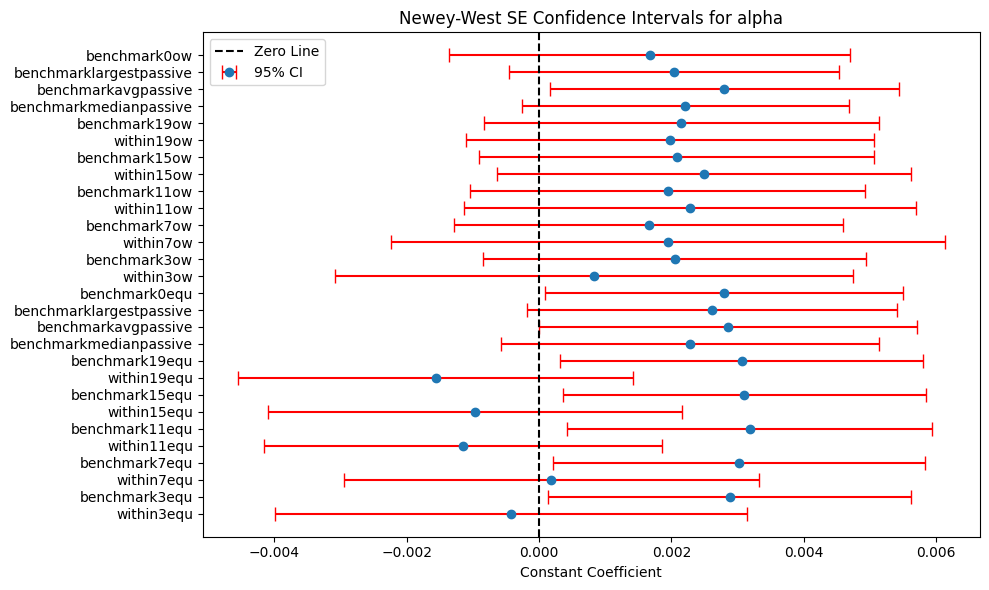

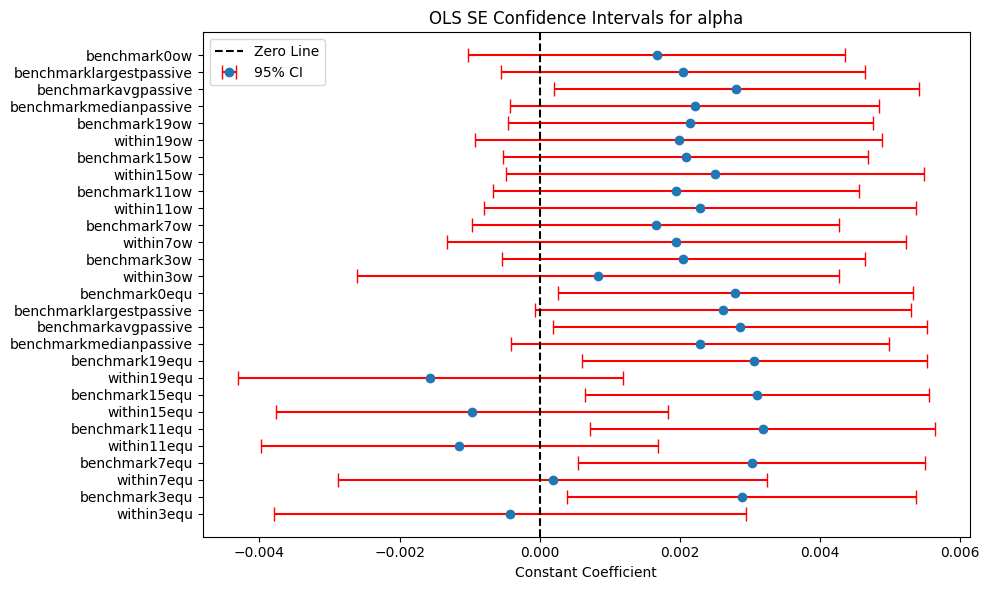

In [34]:
import matplotlib.pyplot as plt

# Function to plot confidence intervals
def plot_confidence_intervals(result_df, title, se_column):
    # Calculate the upper and lower bounds of the 95% confidence interval
    result_df['lower'] = result_df['Constant Coefficient'] - 1.96 * result_df[se_column]
    result_df['upper'] = result_df['Constant Coefficient'] + 1.96 * result_df[se_column]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.errorbar(result_df['Constant Coefficient'], result_df.index,
                 xerr=[result_df['Constant Coefficient'] - result_df['lower'], result_df['upper'] - result_df['Constant Coefficient']], 
                 fmt='o', ecolor='r', capsize=5, label='95% CI', linestyle='None')
    plt.axvline(0, color='k', linestyle='--', label='Zero Line')
    plt.yticks(result_df.index, result_df['Decile'])
    plt.xlabel('Constant Coefficient')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot Newey-West Confidence Intervals
plot_confidence_intervals(result_df, 'Newey-West SE Confidence Intervals for alpha', 'Newey-West Standard Error')

# Plot OLS Confidence Intervals
plot_confidence_intervals(result_df, 'OLS SE Confidence Intervals for alpha', 'Standard Error')

## Equal Weighted Long Short Returns

In [35]:
# Function to calculate long-short weighted returns for a given decile column
def calculate_equ_w_long_short_returns(decile_col):
        # Function to calculate weighted returns for a decile
    def calculate_equ_w_weighted_returns(df):
        # Calculate the equal weight for each stock
        equal_weight = 1 / len(df)
        # Multiply each stock's return by its equal weight and sum the results to get the weighted return
        equal_weighted_return = (df['RET'] * equal_weight).sum()
        return equal_weighted_return
    # Filter for decile 1 and decile 10
    decile_1 = me_return_decile[me_return_decile[decile_col] == 1]
    decile_10 = me_return_decile[me_return_decile[decile_col] == 10]
    
    # Calculate last month market-cap-weighted returns for decile 1
    weighted_returns_1 = decile_1.groupby('date').apply(calculate_equ_w_weighted_returns)
    
    # Calculate last month market-cap-weighted returns for decile 10
    weighted_returns_10 = decile_10.groupby('date').apply(calculate_equ_w_weighted_returns)
    # Calculate long-short returns
    long_short_returns = weighted_returns_1.subtract(weighted_returns_10, fill_value=0)
    
    return long_short_returns

In [36]:
# Initialize a DataFrame to store combined results
combined_equ_w_long_short_returns = pd.DataFrame()

# Loop through each decile column and calculate long-short returns
for decile_col in decile_columns:
    long_short_ret = calculate_equ_w_long_short_returns(decile_col)
    combined_equ_w_long_short_returns[f'{decile_col}_long_short_ret'] = long_short_ret

# Reset the index to make 'date' a column
combined_equ_w_long_short_returns = combined_equ_w_long_short_returns.reset_index()

combined_equ_w_long_short_returns = pd.merge(combined_equ_w_long_short_returns, ff_factors, on='date', how='left')
# Convert 'Mkt-RF', 'SMB', 'HML', and 'RF' columns to numeric, coercing errors to NaN
combined_equ_w_long_short_returns['Mkt-RF'] = pd.to_numeric(combined_long_short_returns['Mkt-RF'], errors='coerce')
combined_equ_w_long_short_returns['SMB'] = pd.to_numeric(combined_long_short_returns['SMB'], errors='coerce')
combined_equ_w_long_short_returns['HML'] = pd.to_numeric(combined_long_short_returns['HML'], errors='coerce')
combined_equ_w_long_short_returns['RF'] = pd.to_numeric(combined_long_short_returns['RF'], errors='coerce')

In [37]:
combined_equ_w_long_short_returns

,date,percent_within_3_equ_w_mean_decile_long_short_ret,percent_benchmark_3_equ_w_mean_decile_long_short_ret,percent_within_7_equ_w_mean_decile_long_short_ret,percent_benchmark_7_equ_w_mean_decile_long_short_ret,percent_within_11_equ_w_mean_decile_long_short_ret,percent_benchmark_11_equ_w_mean_decile_long_short_ret,percent_within_15_equ_w_mean_decile_long_short_ret,percent_benchmark_15_equ_w_mean_decile_long_short_ret,percent_within_19_equ_w_mean_decile_long_short_ret,percent_benchmark_19_equ_w_mean_decile_long_short_ret,percent_benchmark_median_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_avg_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_largest_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_0_equ_w_mean_decile_long_short_ret,percent_within_3_ow_weighted_decile_long_short_ret,percent_benchmark_3_ow_weighted_decile_long_short_ret,percent_within_7_ow_weighted_decile_long_short_ret,percent_benchmark_7_ow_weighted_decile_long_short_ret,percent_within_11_ow_weighted_decile_long_short_ret,percent_benchmark_11_ow_weighted_decile_long_short_ret,percent_within_15_ow_weighted_decile_long_short_ret,percent_benchmark_15_ow_weighted_decile_long_short_ret,percent_within_19_ow_weighted_decile_long_short_ret,percent_benchmark_19_ow_weighted_decile_long_short_ret,percent_benchmark_median_passive_ow_weighted_decile_long_short_ret,percent_benchmark_avg_passive_ow_weighted_decile_long_short_ret,percent_benchmark_largest_passive_ow_weighted_decile_long_short_ret,percent_benchmark_0_ow_weighted_decile_long_short_ret,Mkt-RF,SMB,HML,RF
0,1985-07,0.022137,-0.014964,0.021827,-0.014964,0.011332,-0.014964,0.016502,-0.014964,0.021063,-0.014964,-0.014964,-0.014964,-0.014964,-0.014964,0.014114,-0.014964,0.020214,-0.014964,0.020842,-0.014964,0.018344,-0.014964,0.017686,-0.014964,-0.014964,-0.014964,-0.014964,-0.014964,-0.74,2.84,-1.62,0.62
1,1985-08,-0.007883,0.000723,-0.011108,0.000723,-0.006626,0.000723,-0.004002,0.000723,-0.010272,0.000723,0.000723,0.000723,0.000723,0.000723,-0.002344,0.000723,-0.006564,0.000723,-0.000839,0.000723,-0.009905,0.000723,-0.009466,0.000723,0.000723,0.000723,0.000723,0.000723,-1.02,-0.30,2.32,0.55
2,1985-09,-0.008812,0.012767,-0.005218,0.012767,-0.006792,0.012767,0.012302,0.012767,0.012793,0.012767,0.012767,0.012767,0.012767,0.012767,-0.026459,0.012767,-0.031658,0.012767,-0.022006,0.012767,0.003196,0.012767,0.006362,0.012767,0.012767,0.012767,0.012767,0.012767,-4.54,-1.59,1.29,0.60
3,1985-10,-0.012842,-0.002444,-0.022466,-0.002444,-0.020012,-0.002444,-0.024162,-0.002444,-0.019055,-0.002444,-0.002444,-0.002444,-0.002444,-0.002444,-0.011915,-0.002444,-0.012588,-0.002444,-0.017759,-0.002444,-0.026719,-0.002444,-0.025158,-0.002444,-0.002444,-0.002444,-0.002444,-0.002444,4.02,-1.51,0.75,0.65
4,1985-11,0.012211,-0.010166,0.018305,-0.010166,0.004393,-0.010166,0.007730,-0.010166,0.007921,-0.010166,-0.010166,-0.010166,-0.010166,-0.010166,0.028540,-0.010166,0.024963,-0.010166,0.011699,-0.010166,0.002861,-0.010166,0.005081,-0.010166,-0.010166,-0.010166,-0.010166,-0.010166,6.48,0.25,-2.85,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,2020-05,0.088849,-0.052819,0.036027,-0.063361,0.039329,-0.061137,-0.017904,-0.069379,-0.024317,-0.068904,-0.056603,-0.083240,-0.051250,-0.043676,0.087122,-0.044471,-0.055406,-0.062717,-0.087141,-0.064366,-0.095917,-0.074842,-0.107941,-0.074288,-0.072526,-0.096019,-0.062575,-0.038647,5.58,2.47,-4.88,0.01
419,2020-06,0.174122,-0.094248,0.133925,-0.102668,0.109690,-0.105374,-0.074658,-0.105871,-0.075170,-0.107668,-0.120190,-0.125033,-0.123365,-0.084544,0.170922,-0.104977,-0.135526,-0.106465,-0.133941,-0.102348,-0.138675,-0.109521,-0.132474,-0.110131,-0.102540,-0.104861,-0.125395,-0.107264,2.46,2.69,-2.20,0.01
420,2020-07,0.017689,-0.031292,0.028622,-0.038079,0.038515,-0.041265,0.039640,-0.043274,0.041346,-0.036133,-0.066204,-0.084144,-0.070067,-0.046268,-0.004187,-0.030617,0.0

In [38]:
combined_equ_w_long_short_returns.describe().round(4)

,percent_within_3_equ_w_mean_decile_long_short_ret,percent_benchmark_3_equ_w_mean_decile_long_short_ret,percent_within_7_equ_w_mean_decile_long_short_ret,percent_benchmark_7_equ_w_mean_decile_long_short_ret,percent_within_11_equ_w_mean_decile_long_short_ret,percent_benchmark_11_equ_w_mean_decile_long_short_ret,percent_within_15_equ_w_mean_decile_long_short_ret,percent_benchmark_15_equ_w_mean_decile_long_short_ret,percent_within_19_equ_w_mean_decile_long_short_ret,percent_benchmark_19_equ_w_mean_decile_long_short_ret,percent_benchmark_median_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_avg_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_largest_passive_equ_w_mean_decile_long_short_ret,percent_benchmark_0_equ_w_mean_decile_long_short_ret,percent_within_3_ow_weighted_decile_long_short_ret,percent_benchmark_3_ow_weighted_decile_long_short_ret,percent_within_7_ow_weighted_decile_long_short_ret,percent_benchmark_7_ow_weighted_decile_long_short_ret,percent_within_11_ow_weighted_decile_long_short_ret,percent_benchmark_11_ow_weighted_decile_long_short_ret,percent_within_15_ow_weighted_decile_long_short_ret,percent_benchmark_15_ow_weighted_decile_long_short_ret,percent_within_19_ow_weighted_decile_long_short_ret,percent_benchmark_19_ow_weighted_decile_long_short_ret,percent_benchmark_median_passive_ow_weighted_decile_long_short_ret,percent_benchmark_avg_passive_ow_weighted_decile_long_short_ret,percent_benchmark_largest_passive_ow_weighted_decile_long_short_ret,percent_benchmark_0_ow_weighted_decile_long_short_ret,Mkt-RF,SMB,HML,RF
count,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000,423.0000
mean,0.0042,0.0006,0.0050,0.0006,0.0043,0.0008,0.0034,0.0007,0.0032,0.0007,0.0007,0.0004,0.0007,0.0004,0.0035,0.0004,0.0026,0.0002,0.0030,0.0003,0.0032,0.0002,0.0030,0.0001,0.0007,0.0006,0.0007,0.0003,0.7078,0.0243,0.0568,0.2605
std,0.0360,0.0276,0.0352,0.0276,0.0340,0.0274,0.0328,0.0274,0.0328,0.0273,0.0271,0.0273,0.0272,0.0279,0.0328,0.0248,0.0321,0.0248,0.0323,0.0246,0.0320,0.0248,0.0325,0.0247,0.0246,0.0245,0.0245,0.0250,4.4789,3.0605,2.9736,0.2093
min,-0.1109,-0.2363,-0.1064,-0.2357,-0.1011,-0.2356,-0.1021,-0.2365,-0.1090,-0.2365,-0.1867,-0.1903,-0.1866,-0.2374,-0.1117,-0.1845,-0.1355,-0.1837,-0.1339,-0.1836,-0.1387,-0.1850,-0.1372,-0.1850,-0.1441,-0.1447,-0.1428,-0.1713,-23.2400,-17.2000,-13.8700,0.0000
25%,-0.0152,-0.0109,-0.0153,-0.0102,-0.0165,-0.0103,-0.0151,-0.0103,-0.0149,-0.0102,-0.0107,-0.0102,-0.0110,-0.0111,-0.0145,-0.0108,-0.0140,-0.0100,-0.0129,-0.0097,-0.0120,-0.0103,-0.0123,-0.0102,-0.0105,-0.0103,-0.0104,-0.0108,-1.9100,-1.8200,-1.6250,0.0400
50%,0.0033,0.0012,0.0043,0.0010,0.0037,0.0012,0.0036,0.0014,0.0034,0.0018,-0.0000,-0.0002,-0.0001,0.0011,0.0022,0.0012,0.0019,0.0010,0.0043,0.0010,0.0038,0.0014,0.0025,0.0009,0.0005,0.0010,0.0002,0.0014,1.1800,0.0700,-0.0300,0.2500
75%,0.0225,0.0136,0.0225,0.0130,0.0225,0.0131,0.0212,0.0128,0.0204,0.0131,0.0137,0.0135,0.0136,0.0135,0.0176,0.0128,0.0196,0.0125,0.0197,0.0124,0.0184,0.0127,0.0199,0.0127,0.0134,0.0132,0.0126,0.0130,3.5100,1.6950,1.6000,0.4300
max,0.1981,0.1301,0.2272,0.1297,0.2194,0.1289,0.2114,0.1295,0.2211,0.1295,0.1142,0.1133,0.1142,0.1321,0.1709,0.1140,0.1257,0.1132,0.1194,0.1133,0.1185,0.1140,0.1169,0.1140,0.0844,0.0818,0.0836,0.1119,13.6500,21.3600,12.4700,0.7900


In [39]:
import statsmodels.api as sm

#from statsmodels.tsa.api import add_constant

# List of decile long-short return columns
decile_cols = combined_equ_w_long_short_returns.columns[1:29]

results = []

for decile_col in decile_cols:
    
    # Select your independent variables (Fama-French factors) and add a constant term for the intercept
    X = combined_equ_w_long_short_returns[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    
    # Select the dependent variable (one of the decile long-short return columns)
    y = combined_equ_w_long_short_returns[decile_col]
    
    # Fit the OLS model with standard errors
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Fit the OLS model with Newey-West standard errors (HAC)
    model_nw = sm.OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags':6})
    
    # Extract the coefficient for the constant term and its standard errors
    const_coeff = model.params['const']
    const_se = model.bse['const']
    const_t = model.tvalues['const']
    const_p = model.pvalues['const']
    
    # Extract the coefficient for the constant term and its Newey-West standard errors
    #const_coeff_nw = model_nw.params['const']
    const_se_nw = model_nw.bse['const']
    const_t_nw = model_nw.tvalues['const']
    const_p_nw = model_nw.pvalues['const']

    decile_name = decile_col.split('_')
    decile_name = decile_name[1]+decile_name[2]+decile_name[3]
    results.append({
        'Decile': decile_name,
        'Constant Coefficient': const_coeff,
        'Standard Error': const_se,
        'Newey-West Standard Error': const_se_nw,
        'OLS P-value':const_p,
        'Newey-West P-value': const_p_nw
    })

# Convert the results list to a DataFrame for easier viewing
results_df = pd.DataFrame(results)


In [40]:
result_df = results_df
# Convert P-values to percentage and round to 2 decimal places
result_df[['OLS P-value', 'Newey-West P-value']] = result_df[['OLS P-value', 'Newey-West P-value']].applymap(lambda x: round(x * 100, 2))
# Function to highlight cells with p-value below 5%
def highlight_pval(val):
    color = 'red' if val < 5 else ''
    return f'background-color: {color}'

# Applying conditional formatting
styled_df = result_df.style.applymap(highlight_pval, subset=['OLS P-value', 'Newey-West P-value'])
styled_df

,Decile,Constant Coefficient,Standard Error,Newey-West Standard Error,OLS P-value,Newey-West P-value
0,within3equ,0.006056,0.001604,0.001830,0.020000,0.090000
1,benchmark3equ,0.000068,0.001198,0.001091,95.450000,95.000000
2,within7equ,0.006779,0.001565,0.001718,0.000000,0.010000
3,benchmark7equ,-0.000043,0.001199,0.001116,97.130000,96.910000
4,within11equ,0.006147,0.001490,0.001580,0.000000,0.010000
5,benchmark11equ,0.000258,0.001202,0.001130,83.030000,81.950000
6,within15equ,0.005046,0.001412,0.001346,0.040000,0.020000
7,benchmark15equ,0.000228,0.001205,0.001137,85.020000,84.130000
8,within19equ,0.004941,0.001421,0.001341,0.060000,0.020000
9,benchmark19equ,0.000236,0.001202,0.001128,84.430000,83.400000


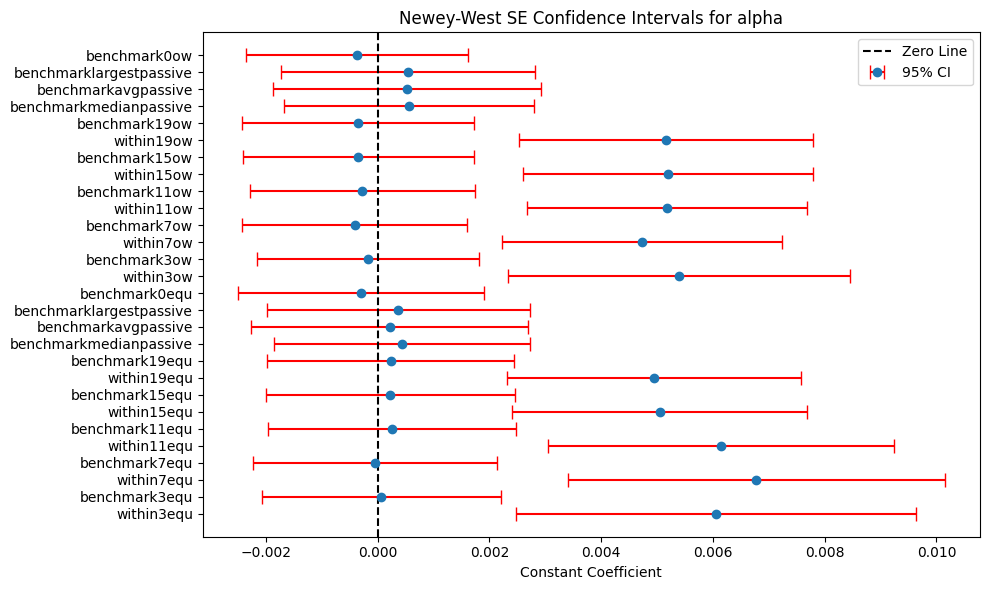

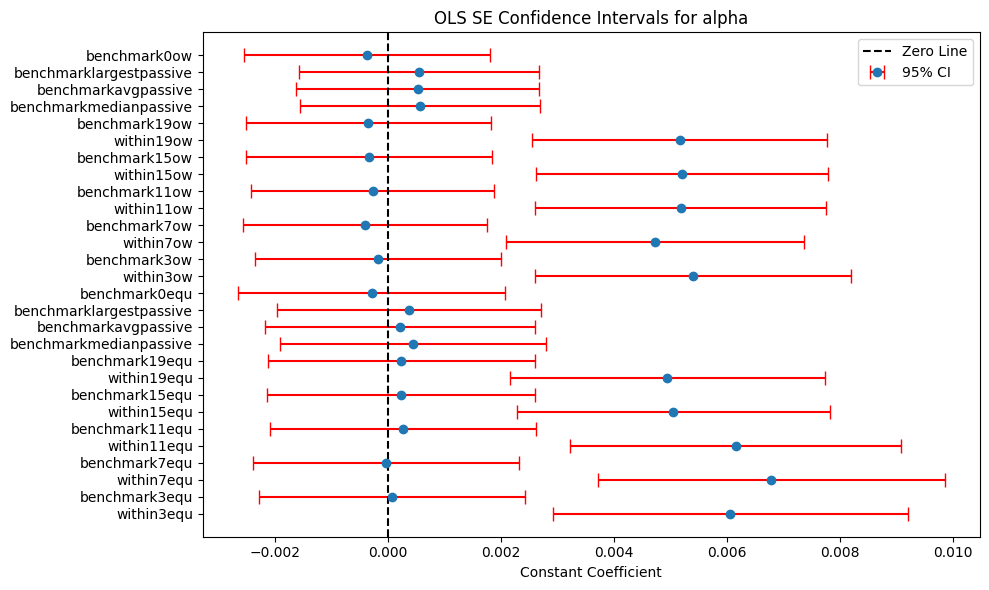

In [41]:
import matplotlib.pyplot as plt

# Function to plot confidence intervals
def plot_confidence_intervals(result_df, title, se_column):
    # Calculate the upper and lower bounds of the 95% confidence interval
    result_df['lower'] = result_df['Constant Coefficient'] - 1.96 * result_df[se_column]
    result_df['upper'] = result_df['Constant Coefficient'] + 1.96 * result_df[se_column]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.errorbar(result_df['Constant Coefficient'], result_df.index,
                 xerr=[result_df['Constant Coefficient'] - result_df['lower'], result_df['upper'] - result_df['Constant Coefficient']], 
                 fmt='o', ecolor='r', capsize=5, label='95% CI', linestyle='None')
    plt.axvline(0, color='k', linestyle='--', label='Zero Line')
    plt.yticks(result_df.index, result_df['Decile'])
    plt.xlabel('Constant Coefficient')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot Newey-West Confidence Intervals
plot_confidence_intervals(result_df, 'Newey-West SE Confidence Intervals for alpha', 'Newey-West Standard Error')

# Plot OLS Confidence Intervals
plot_confidence_intervals(result_df, 'OLS SE Confidence Intervals for alpha', 'Standard Error')